<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/29_finetuned_LLM_spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coding a fine-tuned LLM spam classification model

### Code from previous notes

In [ ]:
# GPT Model

import requests
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(123)
torch.cuda.manual_seed_all(123)

class GPTModel(nn.Module):
    class LayerNorm(nn.Module):
      def __init__(self, emb_dim):
          super().__init__()
          self.eps = 1e-5
          self.scale = nn.Parameter(torch.ones(emb_dim))
          self.shift = nn.Parameter(torch.zeros(emb_dim))

      def forward(self, x):
          mean = x.mean(dim=-1, keepdim=True)
          var = x.var(dim=-1, keepdim=True, unbiased=False)
          norm_x = (x - mean) / torch.sqrt(var + self.eps)
          return self.scale * norm_x + self.shift

    class GELU(nn.Module):
      def __init__(self) -> None:
        super().__init__()

      def forward(self, x):
        # approx GeLu function
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

    class FeedForward(nn.Module):
      def __init__(self, cfg):
          super().__init__()
          self.layers = nn.Sequential(
              nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
              GPTModel.GELU(),
              nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
          )

      def forward(self, x):
          return self.layers(x)

    class MultiHeadAttention(nn.Module):
      def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
          super().__init__()
          assert (d_out % num_heads == 0), \
              "d_out must be divisible by num_heads"

          self.d_out = d_out
          self.num_heads = num_heads
          self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

          self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
          self.dropout = nn.Dropout(dropout)
          self.register_buffer(
              "mask",
              torch.triu(torch.ones(context_length, context_length),
                        diagonal=1)
          )

      def forward(self, x):
          b, num_tokens, d_in = x.shape

          keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
          queries = self.W_query(x)
          values = self.W_value(x)

          # We implicitly split the matrix by adding a `num_heads` dimension
          # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
          keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
          values = values.view(b, num_tokens, self.num_heads, self.head_dim)
          queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

          # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
          keys = keys.transpose(1, 2)
          queries = queries.transpose(1, 2)
          values = values.transpose(1, 2)

          # Compute scaled dot-product attention (aka self-attention) with a causal mask
          attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

          # Original mask truncated to the number of tokens and converted to boolean
          mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

          # Use the mask to fill attention scores
          attn_scores.masked_fill_(mask_bool, -torch.inf)

          attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
          attn_weights = self.dropout(  attn_weights)

          # Shape: (b, num_tokens, num_heads, head_dim)
          context_vec = (attn_weights @ values).transpose(1, 2)

          # Combine heads, where self.d_out = self.num_heads * self.head_dim
          context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
          context_vec = self.out_proj(context_vec) # optional projection

          return context_vec

    class TransformerBlock(nn.Module):
        def __init__(self, cfg):
            super().__init__()
            self.att = GPTModel.MultiHeadAttention(
                d_in=cfg["emb_dim"],
                d_out=cfg["emb_dim"],
                context_length=cfg["context_length"],
                num_heads=cfg["n_heads"],
                dropout=cfg["drop_rate"],
                qkv_bias=cfg["qkv_bias"])
            self.ff = GPTModel.FeedForward(cfg)
            self.norm1 = GPTModel.LayerNorm(cfg["emb_dim"])
            self.norm2 = GPTModel.LayerNorm(cfg["emb_dim"])
            self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

        def forward(self, x):
            # Shortcut connection for attention block
            shortcut = x
            x = self.norm1(x)
            x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
            x = self.drop_shortcut(x)
            x = x + shortcut  # Add the original input back

            # Shortcut connection for feed forward block
            shortcut = x
            x = self.norm2(x)
            x = self.ff(x)
            x = self.drop_shortcut(x)
            x = x + shortcut  # Add the original input back

            return x

    # GPTModel itself
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[GPTModel.TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = GPTModel.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds

        # dropout helps in generalization and avoid overfitting
        x = self.drop_emb(x)
        x = self.trf_blocks(x)

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx



In [ ]:
class TokenUtils:
  @staticmethod
  def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

  @staticmethod
  def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


In [ ]:
import os
import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import numpy as np


class GPT2Weightloader:

  @staticmethod
  def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        GPT2Weightloader.download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = GPT2Weightloader.load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

  @staticmethod
  def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        response = requests.get(download_url, stream=True, timeout=60)
        response.raise_for_status()

        file_size = int(response.headers.get("Content-Length", 0))

        # Check if file exists and has same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size and file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return True

        block_size = 1024  # 1 KB
        desc = os.path.basename(download_url)
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=desc) as progress_bar:
            with open(destination, "wb") as file:
                for chunk in response.iter_content(chunk_size=block_size):
                    if chunk:
                        file.write(chunk)
                        progress_bar.update(len(chunk))
        return True

    try:
        if _attempt_download(url):
            return
    except requests.exceptions.RequestException:
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except requests.exceptions.RequestException:
                pass

        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

  # Alternative way using `requests`
  """
  def download_file(url, destination):
      # Send a GET request to download the file in streaming mode
      response = requests.get(url, stream=True)

      # Get the total file size from headers, defaulting to 0 if not present
      file_size = int(response.headers.get("content-length", 0))

      # Check if file exists and has the same size
      if os.path.exists(destination):
          file_size_local = os.path.getsize(destination)
          if file_size == file_size_local:
              print(f"File already exists and is up-to-date: {destination}")
              return

      # Define the block size for reading the file
      block_size = 1024  # 1 Kilobyte

      # Initialize the progress bar with total file size
      progress_bar_description = url.split("/")[-1]  # Extract filename from URL
      with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
          # Open the destination file in binary write mode
          with open(destination, "wb") as file:
              # Iterate over the file data in chunks
              for chunk in response.iter_content(block_size):
                  progress_bar.update(len(chunk))  # Update progress bar
                  file.write(chunk)  # Write the chunk to the file
  """

  @staticmethod
  def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

  @staticmethod
  def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

  @staticmethod
  def load_weights_into_gpt(gpt, params):
      gpt.pos_emb.weight = GPT2Weightloader.assign(gpt.pos_emb.weight, params['wpe'])
      gpt.tok_emb.weight = GPT2Weightloader.assign(gpt.tok_emb.weight, params['wte'])

      for b in range(len(params["blocks"])):
          q_w, k_w, v_w = np.split(
              (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
          gpt.trf_blocks[b].att.W_query.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_query.weight, q_w.T)
          gpt.trf_blocks[b].att.W_key.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_key.weight, k_w.T)
          gpt.trf_blocks[b].att.W_value.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_value.weight, v_w.T)

          q_b, k_b, v_b = np.split(
              (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
          gpt.trf_blocks[b].att.W_query.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_query.bias, q_b)
          gpt.trf_blocks[b].att.W_key.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_key.bias, k_b)
          gpt.trf_blocks[b].att.W_value.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_value.bias, v_b)

          gpt.trf_blocks[b].att.out_proj.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.out_proj.weight,
              params["blocks"][b]["attn"]["c_proj"]["w"].T)
          gpt.trf_blocks[b].att.out_proj.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.out_proj.bias,
              params["blocks"][b]["attn"]["c_proj"]["b"])

          gpt.trf_blocks[b].ff.layers[0].weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[0].weight,
              params["blocks"][b]["mlp"]["c_fc"]["w"].T)
          gpt.trf_blocks[b].ff.layers[0].bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[0].bias,
              params["blocks"][b]["mlp"]["c_fc"]["b"])
          gpt.trf_blocks[b].ff.layers[2].weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[2].weight,
              params["blocks"][b]["mlp"]["c_proj"]["w"].T)
          gpt.trf_blocks[b].ff.layers[2].bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[2].bias,
              params["blocks"][b]["mlp"]["c_proj"]["b"])

          gpt.trf_blocks[b].norm1.scale = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm1.scale,
              params["blocks"][b]["ln_1"]["g"])
          gpt.trf_blocks[b].norm1.shift = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm1.shift,
              params["blocks"][b]["ln_1"]["b"])
          gpt.trf_blocks[b].norm2.scale = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm2.scale,
              params["blocks"][b]["ln_2"]["g"])
          gpt.trf_blocks[b].norm2.shift = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm2.shift,
              params["blocks"][b]["ln_2"]["b"])

      gpt.final_norm.scale = GPT2Weightloader.assign(gpt.final_norm.scale, params["g"])
      gpt.final_norm.shift = GPT2Weightloader.assign(gpt.final_norm.shift, params["b"])
      gpt.out_head.weight = GPT2Weightloader.assign(gpt.out_head.weight, params["wte"])


In [ ]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path
import pandas as pd


class SpamDatasetPreparer:
    def __init__(self,
                 url="https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip",
                 zip_path="sms_spam_collection.zip",
                 extracted_path="sms_spam_collection",
                 data_file_name="SMSSpamCollection.tsv"):

        self.url = url
        self.zip_path = Path(zip_path)
        self.extracted_path = Path(extracted_path)
        self.data_file_path = self.extracted_path / data_file_name

    def download_and_unzip(self):
        """Downloads and extracts the dataset if not already present."""
        if self.data_file_path.exists():
            print(f"{self.data_file_path} already exists. Skipping download and extraction.")
            return

        ssl_context = ssl._create_unverified_context()

        # Download the zip
        print("Downloading dataset...")
        with urllib.request.urlopen(self.url, context=ssl_context) as response:
            with open(self.zip_path, "wb") as out_file:
                out_file.write(response.read())

        # Unzip the file
        print("Extracting dataset...")
        with zipfile.ZipFile(self.zip_path, "r") as zip_ref:
            zip_ref.extractall(self.extracted_path)

        # Rename extracted file to .tsv
        original_file_path = self.extracted_path / "SMSSpamCollection"
        os.rename(original_file_path, self.data_file_path)
        print(f"File downloaded and saved as {self.data_file_path}")

    def load_dataframe(self):
        """Loads the TSV file into a DataFrame."""
        df = pd.read_csv(self.data_file_path, sep="\t", header=None, names=["Label", "Text"])
        return df

    def create_balanced_dataset(self, df):
        """Creates a balanced dataset with equal spam and ham samples."""
        num_spam = df[df["Label"] == "spam"].shape[0]
        ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
        balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
        balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
        return balanced_df

    def random_split(self, df, train_frac=0.7, validation_frac=0.1):
        """Randomly splits dataset into train, validation, and test sets."""
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        train_end = int(len(df) * train_frac)
        validation_end = train_end + int(len(df) * validation_frac)

        train_df = df[:train_end]
        validation_df = df[train_end:validation_end]
        test_df = df[validation_end:]
        return train_df, validation_df, test_df

    def prepare(self):
        """Full pipeline: download, load, balance, split, and save CSVs."""
        self.download_and_unzip()
        df = self.load_dataframe()
        balanced_df = self.create_balanced_dataset(df)
        train_df, validation_df, test_df = self.random_split(balanced_df)

        # Save splits
        train_df.to_csv("train.csv", index=False)
        validation_df.to_csv("validation.csv", index=False)
        test_df.to_csv("test.csv", index=False)

        print("Datasets saved: train.csv, validation.csv, test.csv")
        return train_df, validation_df, test_df


preparer = SpamDatasetPreparer()
train_df, val_df, test_df = preparer.prepare()

print(len(train_df))
print(len(val_df))
print(len(test_df))

Extracting dataset...
File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv
Datasets saved: train.csv, validation.csv, test.csv
1045
149
300


In [ ]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

120


In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [ ]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = GPT2Weightloader.download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
GPT2Weightloader.load_weights_into_gpt(model, params)
model.eval();

text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate(
    model=model,
    idx=TokenUtils.text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(TokenUtils.token_ids_to_text(token_ids, tokenizer))

for param in model.parameters():
    param.requires_grad = False

# Then, we replace the output layer (model.out_head),
# which originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary):

torch.manual_seed(123)
torch.cuda.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)


for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

print("Last output token:", outputs[:, -1, :])


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 66.4kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.25MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 261kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:35<00:00, 5.23MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.35MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 739kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 635kiB/s]


Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner
Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])
Last output token: tensor([[-3.5983,  3.9902]])


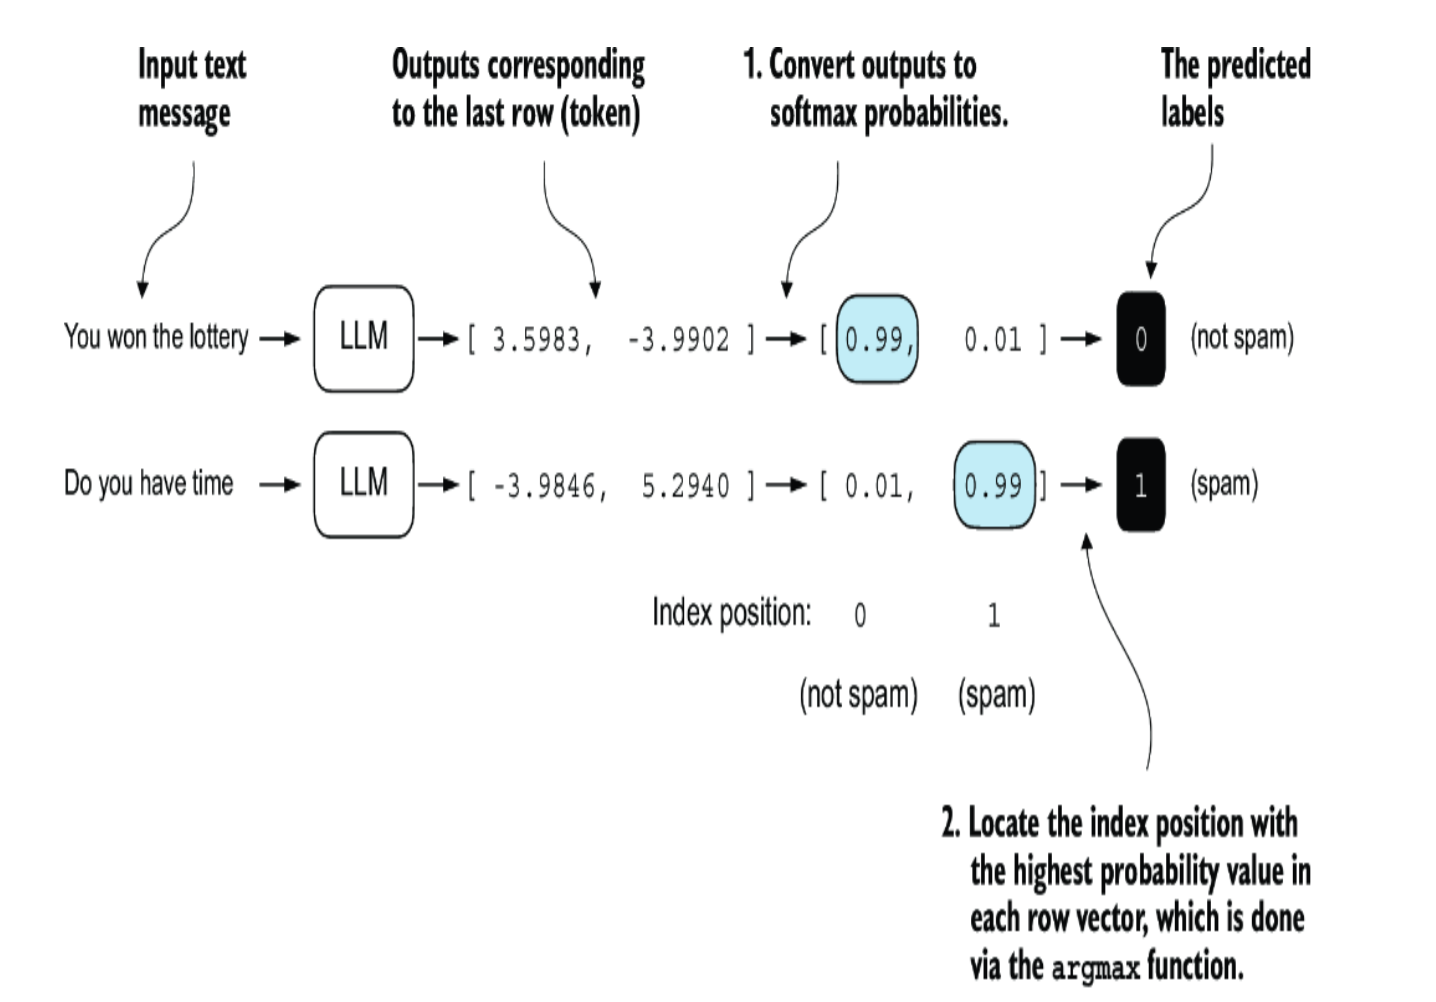

## CALCULATING THE CLASSIFICATION LOSS AND ACCURACY

So far we have prepared the dataset, loaded a pretrained model, and modified it for classification-finetuning.
           
Before we proceed with the finetuning itself, only one small part remains: implementing the model evaluation functions used during
finetuning.

Previously, we computed the token ID of the next token generated by the LLM by converting the 50,257 outputs into probabilities via the softmax function and then returning the position of the highest probability via the argmax function.

Now, we take the same approach to calculate whether the model outputs a "spam" or "not spam" prediction for a given input, with the only difference being that we work with 2-dimensional instead of 50,257-dimensional outputs.

In [ ]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In this case, the code returns 1, meaning the model predicts that the input text is "spam."

Using the softmax function here is optional because the largest outputs directly correspond to the highest probability scores.

Hence, we can simplify the code as follows, without using softmax:

In [ ]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


To determine the classification accuracy, we apply the argmax-based prediction code to all examples in the dataset and calculate the proportion of correct predictions.

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123)
torch.cuda.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


As we can see, the prediction accuracies are near a random prediction, which would be 50% in this case.

To improve the prediction accuracies, we need to finetune the model.

Classification accuracy is not a differentiable function, so we use **cross entropy loss** as a proxy to maximize accuracy.

This is the same cross entropy loss discussed earlier.

Accordingly, the calc_loss_batch function remains the same as in earlier, with one adjustment: we focus on optimizing only the last token, model rather than all tokens.

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

We use the calc_loss_batch function to compute the loss for a single batch obtained from the previously defined data loaders. To calculate the loss for all batches in a data loader, we
define the calc_loss_loader function

In [ ]:
# Same as previous notes
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


## FINETUNING THE MODEL ON SUPERVISED DATA

we will define and use the training function to finetune the pretrained LLM and improve its spam classification accuracy.
    
The training loop is the same overall training loop we used earlier, with the only difference being that we calculate the classification accuracy instead of generating a sample text for evaluating the
model.

The training function also closely mirrors the train_model_simple function used for pretraining the model earlier.
                                    
The only two distinctions are that we now track the number of training examples seen (examples_seen) instead of the number of tokens, and we calculate the accuracy after each epoch instead of printing a sample text:

Step 1: Set model to training mode

Step 2: Reset loss gradients from previous batch iteration

Step 3: Calculate loss gradients

Step 4: Update model weights using loss gradients

Step 5: New: track examples instead of tokens

Step 6: Optional evaluation step

Step 7: Calculate accuracy after each epoch

In [15]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# Overall the same as `train_model_simple`
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [16]:
import time

start_time = time.time()

torch.manual_seed(123)
torch.cuda.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 1.07 mi

In [17]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

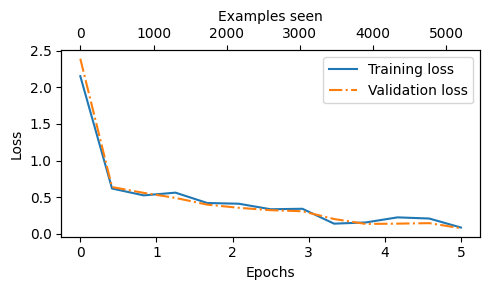

In [18]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

As we can see based on the sharp downward slope, the model is learning well from the training data, and there is little to no indication of overfitting; that is, there is no
noticeable gap between the training and validation set losses.

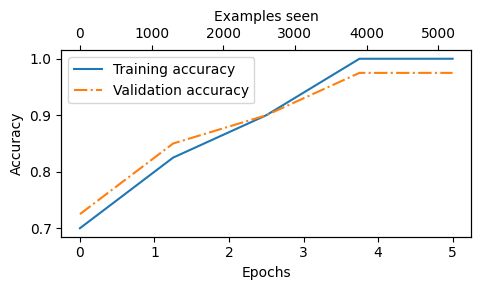

In [19]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

The model achieves a relatively high training and validation accuracy after epochs 4 and 5.
    
However, it's important to note that we previously set eval_iter=5 when using the train_classifier_simple function, which means our estimations of training and validation performance were based on only 5 batches for efficiency during training.

Now, we will calculate the performance metrics for the training, validation, and test sets across the entire dataset.

In [20]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


The training and test set performances are almost identical.

A slight discrepancy between the training and test set accuracies suggests minimal overfitting of the training data.

This situation is common, but the gap could potentially be minimized by adjusting the model's settings, such as increasing the dropout rate (drop_rate) or the weight_decay parameter in the optimizer configuration.

## USING THE LLM AS A SPAM CLASSIFIER

Step 1: Prepare inputs to the model

Step 2: Truncate sequences if they too long
    
Step 3: Pad sequences to the longest sequence

Step 4: Add batch dimension

Step 5: Model inference without gradient tracking
    
Step 6: Logits of the last output token

Step 7: Return the classified result

In [21]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [22]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [23]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


Finally, let's save the model in case we want to reuse the model later without having to train it again using the torch.save method

In [24]:
torch.save(model.state_dict(), "review_classifier.pth")


In [25]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>